In [216]:
library(dplyr)
library(zoo)
library(tseries)

# Chargement et préparation

Les données qui seront analysées sont la valeur quotidienne de l'indice CAC40, depuis l'année 1995 jusqu'à aujourd'hui. Elle proviennent du site MarketWatch.

In [217]:
# Source: https://www.marketwatch.com/investing/index/PX1?countrycode=FR (MarketWatch)
raw_data <- read.csv("data/CAC40_daily.csv")

# ne garder que les variables pertinentes pour notre étude
df <- data.frame(raw_data)[c("Date", "High", "Low", "Open")]

# Convertir les dates
df$Date <- as.Date(df$Date)

In [218]:
summary(df$Open)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   1438    3051    4213    4213    5325    8242     147 

Ces données comportent plusieurs valeurs nulles. Il n'est pas possible en l'état de travailler avec des valeurs nulles, il faut donc les supprimer. Une solution consisterait à supprimer les lignes incomplètes mais cela créerait des trous. La solution choisie ici consiste à remplacer les valeurs manquantes par la moyenne des prix des jours précédent et suivant. En effet cela permettra de conserver la tendance tout en ayant des données relativement lisses dans le temps. 

In [219]:
# Si une donnée manque, utiliser la moyenne des jours précédent et suivants
df$Open <- na.approx(df$Open)
df$High <- na.approx(df$High)
df$Low <- na.approx(df$Low)

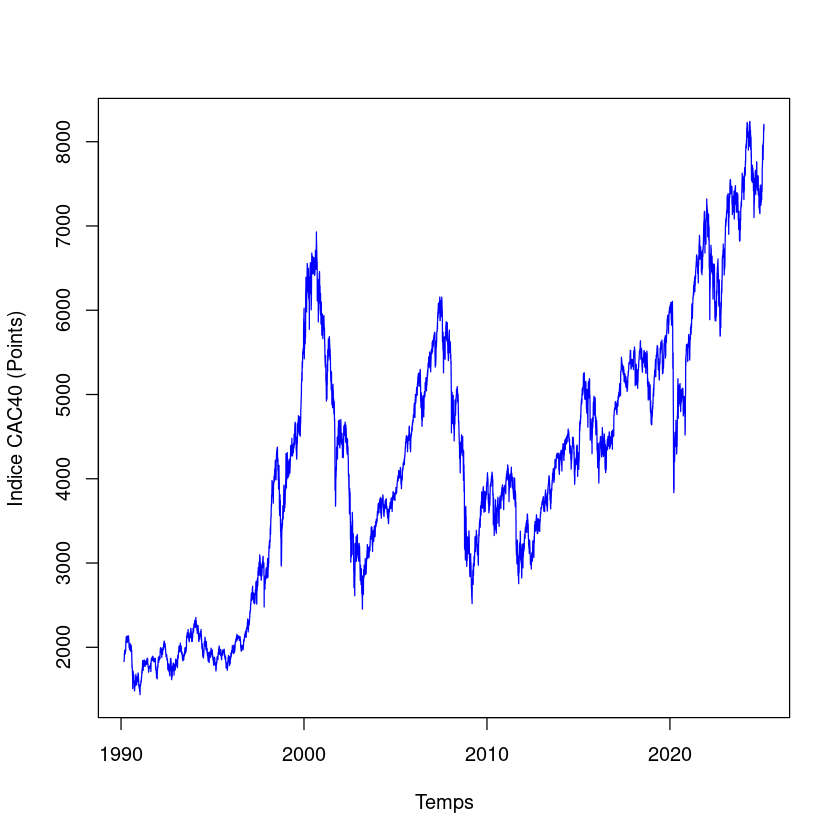

In [220]:
plot(df$Date, df$Open, type="l", col="blue", xlab="Temps", ylab="Indice CAC40 (Points)")

Les données sont très complexes et on sait avec le recul que différentes périodes correspondent à différentes logiques / régimes pour cette courbe. Par exemple, la crise économique de 2008 ou bien celle de 2020 ne peuvent pas êtres prédites à l'avance uniquement via les données précedentes, et changent complètement le modèle de la courbe.
Par conséquent, nous allons restreindre notre étude aux année 1995-1996.

In [221]:
# On choisit un sous-ensemble des données
train_begin <- as.Date("2000-01-01")
train_end <- as.Date("2002-01-01")
test_end <- as.Date("2002-06-01")

train_df <- df[df$Date >= train_begin & df$Date < train_end,]
test_df <- df[df$Date >= train_end & df$Date < test_end,]


# Éxploration

Utilisation d'une moyenne mobile pour obtenir une courbe moins bruitée

In [222]:
moving_average <- stats::filter(train_df$Open, filter=array(1/32, dim=32), circular=FALSE, sides=2, method="convolution")

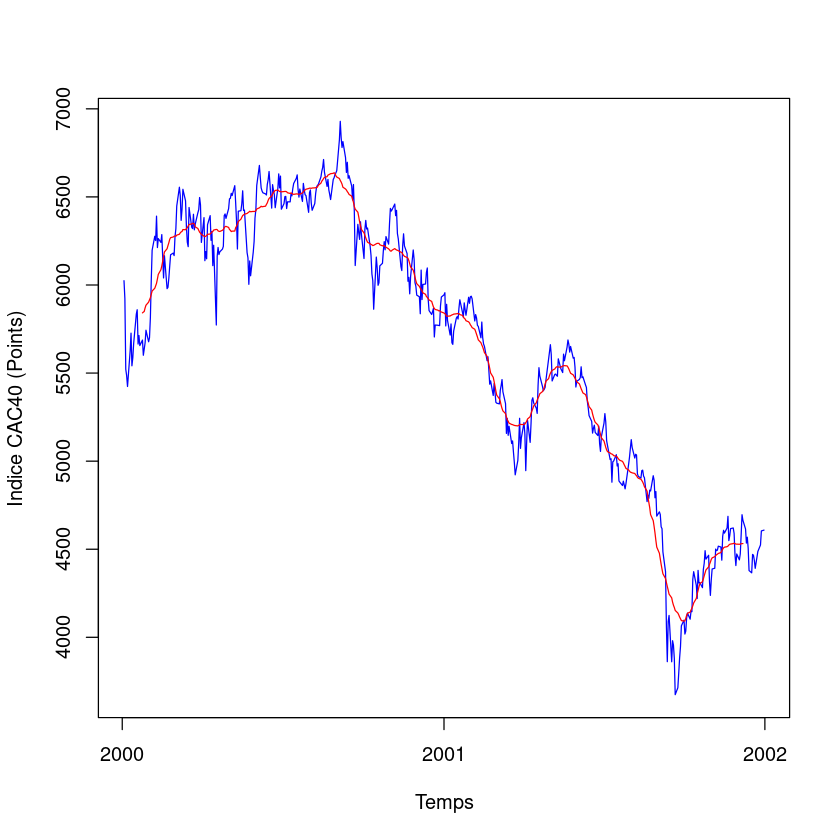

In [223]:
plot(train_df$Date, train_df$Open, type="l", col="blue", xlab="Temps", ylab="Indice CAC40 (Points)")
lines(train_df$Date, moving_average, type="l", col="red")

# Décomposition

## Saisonnalié

La courbe de l'indice CAC40 est soumise aux lois du marché, par conséquent toute saisonnalité est une opportunité pour un tiers d'obtenir un bénéfice, ce qui diminue la composante saisonniaire. On ne s'attend pas à observer de saisonnalité ce qui se vérifie visuellement sur la courbe.

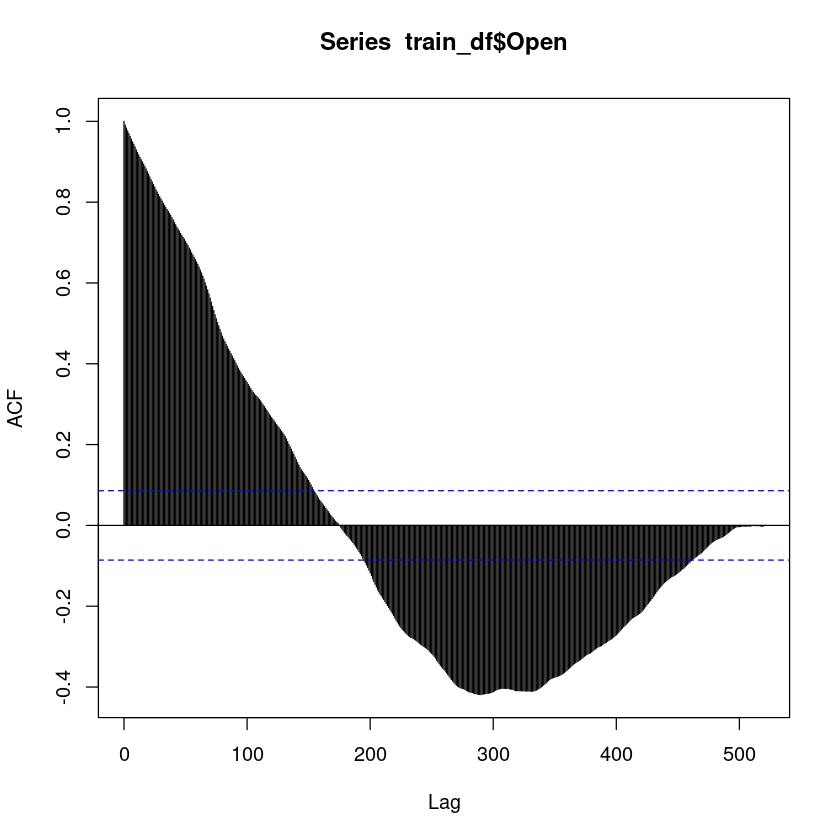

In [224]:
acf(train_df$Open, lag.max=length(train_df$Open))

Observations: Les valeurs de l'autocorrelation sont statistiquement significatives mais ses pics n'apparaissent pas à intervalles réguliers, et ne sont pas assez nombreux pour conclure sur l'enventuelle fréquence de ces saisons.

## Tendance


### Modèle linéaire

Une première approche pour calculer la tendance de l'indice est d'utiliser un simple modèle linéaire pour prédire les valeurs connues.

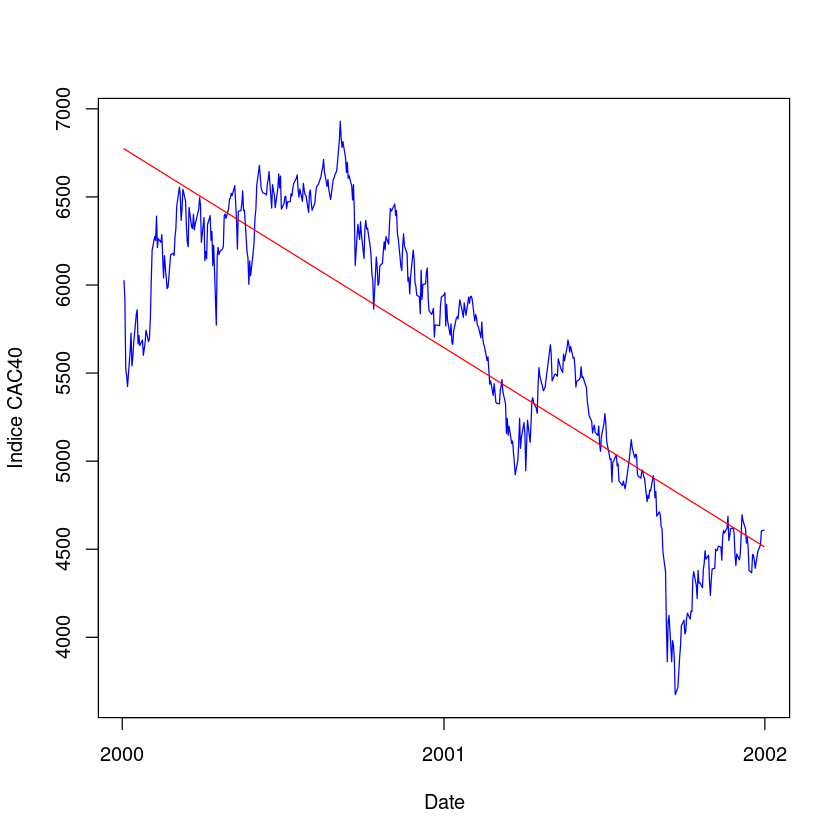

In [225]:
linear_model <- lm(train_df$Open ~ train_df$Date)
plot(train_df$Date, train_df$Open, type="l", col="blue", xlab="Date", ylab="Indice CAC40")

model_prediction <- data.frame(
  Date = seq(as.Date("1995-01-01"), by = "day", length.out = length(train_df$Open))
)

model_prediction$predicted <- predict(linear_model, newdata = model_prediction)
lines(train_df$Date, model_prediction$predicted, col="red")

In [226]:
summary(linear_model)


Call:
lm(formula = train_df$Open ~ train_df$Date)

Residuals:
     Min       1Q   Median       3Q      Max 
-1336.56  -192.99    49.28   291.85   919.21 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)   40763.9272   961.3761   42.40   <2e-16 ***
train_df$Date    -3.1017     0.0849  -36.53   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 408 on 519 degrees of freedom
Multiple R-squared:   0.72,	Adjusted R-squared:  0.7195 
F-statistic:  1335 on 1 and 519 DF,  p-value: < 2.2e-16


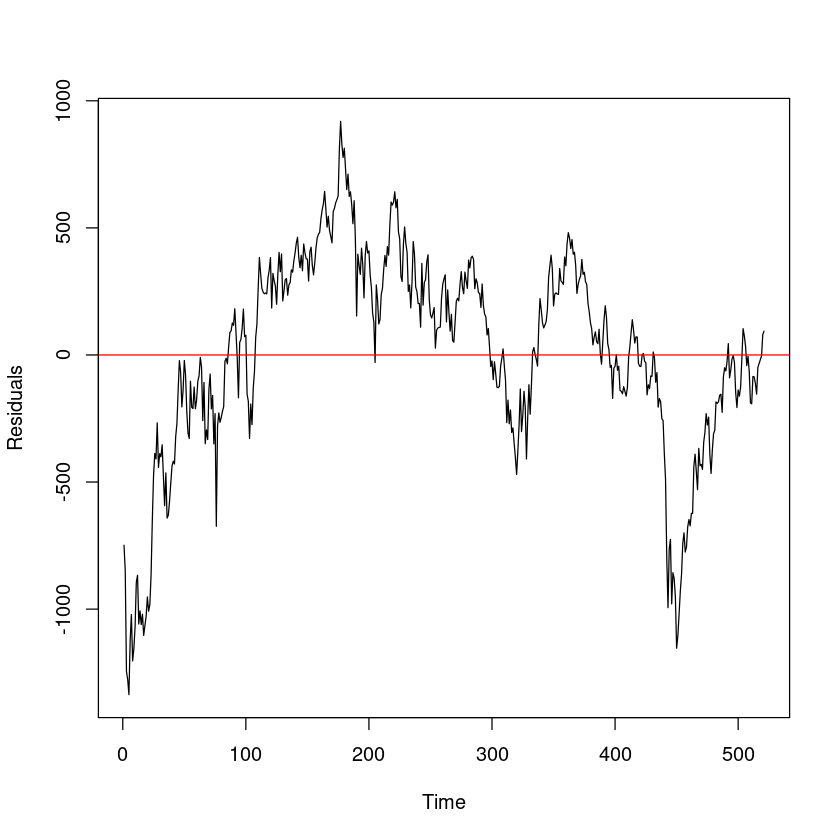

In [227]:
plot(linear_model$residuals, type="l", xlab="Time", ylab="Residuals")
abline(0, 0, col="red")

In [228]:
adf.test(linear_model$residuals)


	Augmented Dickey-Fuller Test

data:  linear_model$residuals
Dickey-Fuller = -3.3346, Lag order = 8, p-value = 0.06472
alternative hypothesis: stationary


### Modèle quadratique

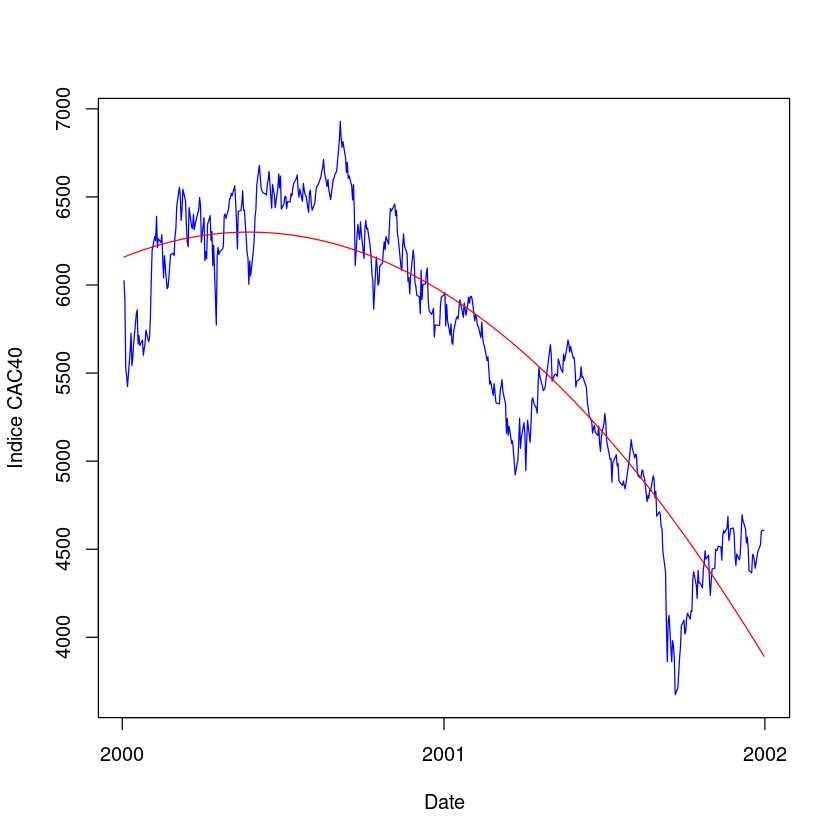

In [229]:
t <- as.numeric(train_df$Date)
tt <- t*t

quadratic_model <- lm(train_df$Open ~ t + tt)
plot(train_df$Date, train_df$Open, type="l", col="blue", xlab="Date", ylab="Indice CAC40")

pred <- data.frame(
  Date = seq(as.Date("1995-01-01"), by = "day", length.out = length(train_df$Open))
)

pred$predicted <- predict(quadratic_model, newdata = pred)
lines(train_df$Date, pred$predicted, col="red")

In [230]:
summary(quadratic_model)



Call:
lm(formula = train_df$Open ~ t + tt)

Residuals:
    Min      1Q  Median      3Q     Max 
-976.66 -142.97   19.55  201.45  715.95 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -8.578e+05  4.225e+04  -20.30   <2e-16 ***
t            1.557e+02  7.466e+00   20.85   <2e-16 ***
tt          -7.012e-03  3.297e-04  -21.27   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 298.4 on 518 degrees of freedom
Multiple R-squared:  0.8506,	Adjusted R-squared:   0.85 
F-statistic:  1474 on 2 and 518 DF,  p-value: < 2.2e-16


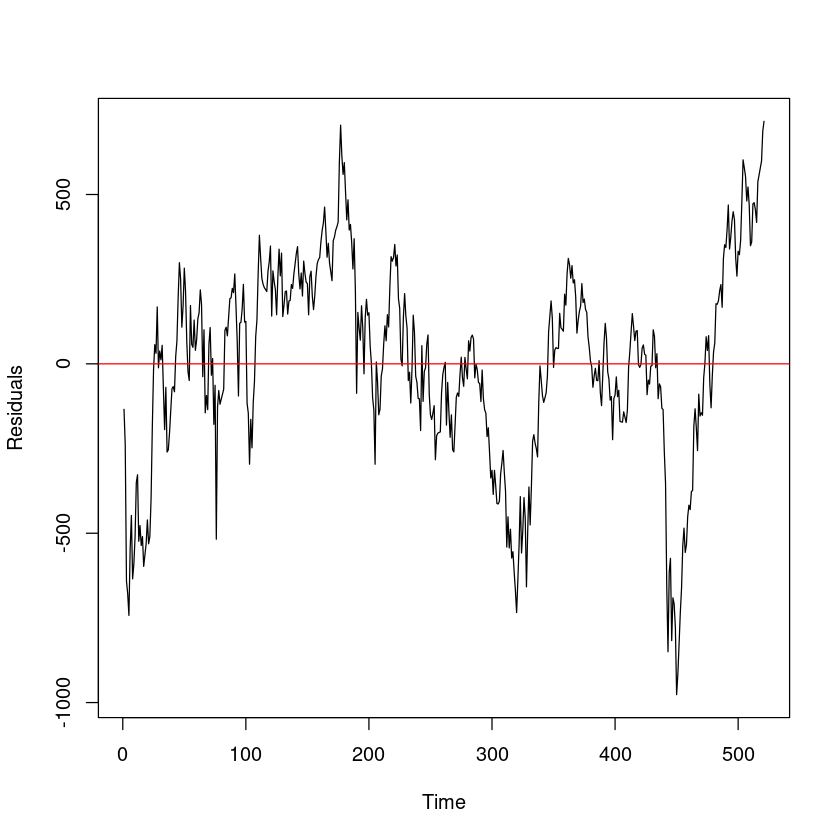

In [231]:
plot(quadratic_model$residuals, type="l", xlab="Time", ylab="Residuals")
abline(0, 0, col="red")

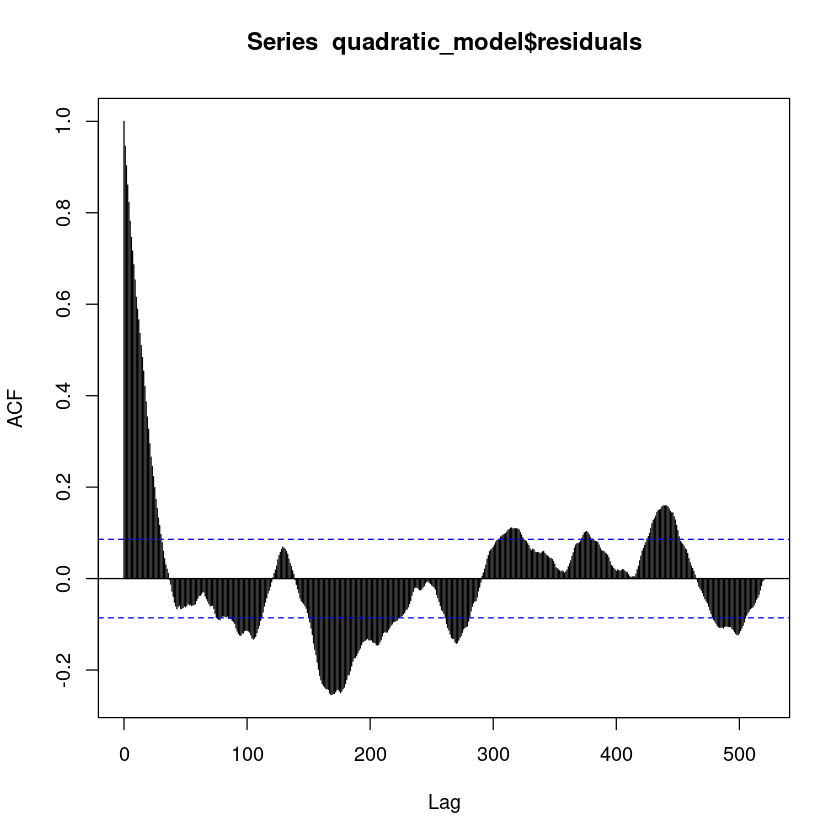

In [232]:
acf(quadratic_model$residuals, lag.max = length(quadratic_model$residuals))

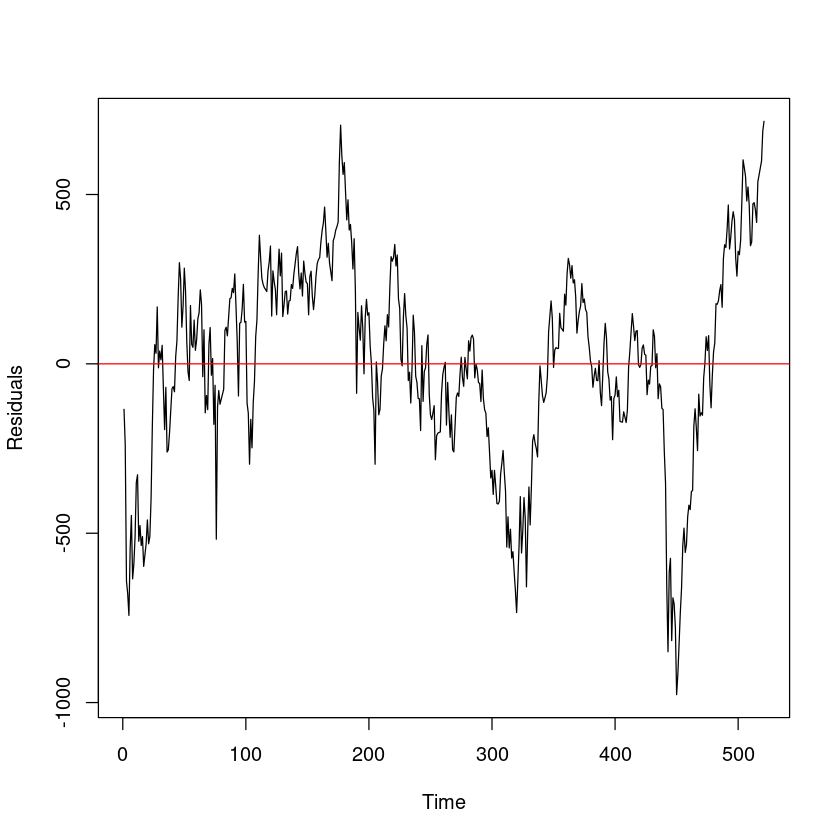

In [233]:
plot(quadratic_model$residuals, type="l", xlab="Time", ylab="Residuals")
abline(0, 0, col="red")

### Lissage exponentiel

In [234]:
exp_model <- HoltWinters(train_df$Open, 0.95, beta = TRUE, gamma = FALSE, seasonal = "additive")

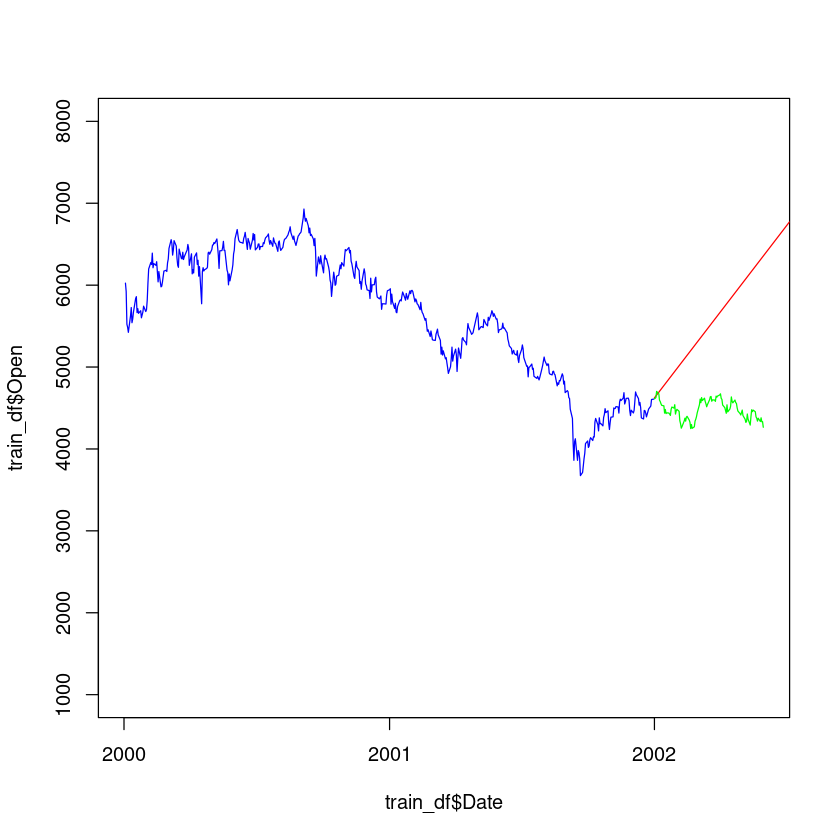

In [235]:
forward_dates <- test_df$Date

plot(
	train_df$Date,
	train_df$Open, 
	type="l",
	col="blue", 
	xlim=c(train_begin, test_end),
	ylim=c(1000, 8000)
)

lines(seq(from=train_end, length.out=200, by="1 day"), predict(exp_model, n.ahead = 200), type="l", col="red")
lines(forward_dates, test_df$Open, col="green", type="l")

# Prediction

Désormais, on vérifie la pertinence des ces modèles par bloc sur la totalité de la donnée. Pour cela chaque modèle est encapsulé dans une fonction afin d'automatiser les prédiction pour des dates quelconques.

In [236]:
test_linear_model <- function(train_df, test_dates, plot_result = FALSE) {
	# Ajustement d'un modèle linéaire
	linear_model <- lm(Open ~ Date, train_df)

	# Prédiction pour la prochaine période
	model_prediction <- data.frame( Date = test_dates	)
	model_prediction$Open <- predict(linear_model, newdata = model_prediction)
	
	if (plot_result) {
		# Recalcul des prédictions sur toute la période
		date_concat <- c(train_df$Date, test_dates)
		full_pred <- data.frame( Date = date_concat )
		full_pred$Open <- predict(linear_model, newdata = full_pred)
		plot(train_df$Date, train_df$Open, type="l", col="blue", xlab="Date", ylab="Indice CAC40")
		lines(full_pred$Date, full_pred$Open, col="red")
		summary(linear_model)

		# Affichage des résiduts autour de 0
		plot(linear_model$residuals, type="l", xlab="Time", ylab="Linear model residuals")
		abline(0, 0, col="red")

		# Test de l'hypothèse de stationnarité
		print(adf.test(linear_model$residuals))
	}

	return(model_prediction)
}

In [237]:
test_exp_smoothing <- function(train_df, test_dates, plot_result = FALSE) {
	exp_model <- HoltWinters(train_df$Open, 0.95, beta = TRUE, gamma = FALSE, seasonal = "additive")

	model_prediction <- data.frame( Date = test_dates )
	model_prediction$Open <- predict(exp_model, n.ahead=length(test_dates))

	if(plot_result) {
		plot(
			train_df$Date,
			train_df$Open, 
			type="l",
			col="blue", 
			xlim=c(train_df$Date[1], test_dates[length(test_dates)]),
			ylim=c(1000, 8000),
			xlab="Temps",
			ylab="Indice CAC40"
		)

		lines(model_prediction$Date, model_prediction$Open, col="red", type="l")
	}

	return(model_prediction)
}

In [238]:
calculate_predictions <- function(model_function, df, begin_date, block_length_days, num_block) {
	result_df <- data.frame()

	for(i in seq(from = 1, to = num_block, by = 1 )) {
		from <- begin_date + block_length_days*i
		to <- begin_date + block_length_days*(i+1)

		test_df <- df[df$Date >= from & df$Date < to,]
		train_df <- df[df$Date >= begin_date & df$Date < from,]
		prediction <- model_function(train_df, test_df$Date, plot_result = FALSE)

		prediction$residuals <- prediction$Open - test_df$Open

		result_df <- rbind(result_df, prediction)
	}

	return(result_df)
}

In [245]:
begin <- as.Date("2000-01-01")
num_block <- 10*12
block_length_days <- 30

linear_result <- calculate_predictions(
	test_linear_model,
	df = df,
	begin_date = begin,
	block_length_days = block_length_days,
	num_block = num_block
)

quadratic_result <- calculate_predictions(
	test_quadratic_model,
	df = df,
	begin_date = begin,
	block_length_days = block_length_days,
	num_block = num_block
)

exp_result <- calculate_predictions(
	test_exp_smoothing,
	df = df,
	begin_date = begin,
	block_length_days = block_length_days,
	num_block = num_block
)

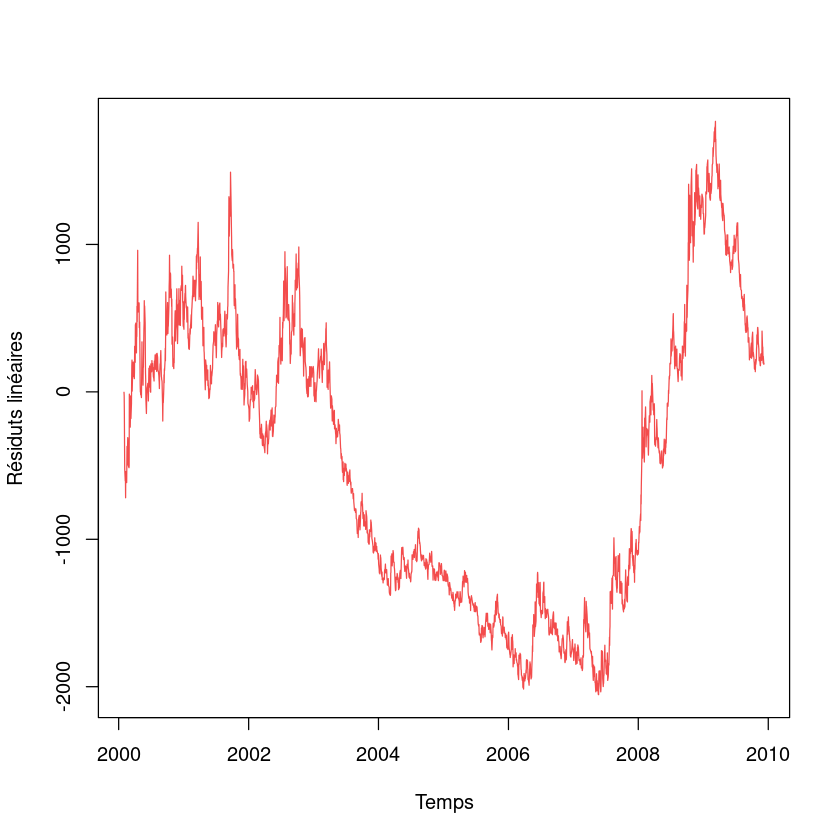

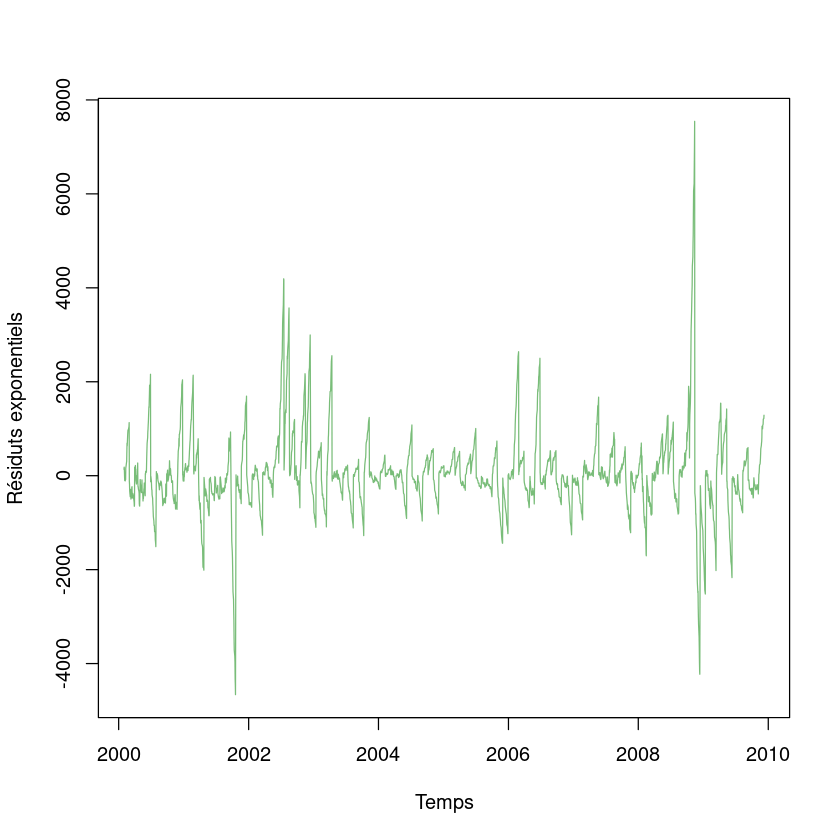

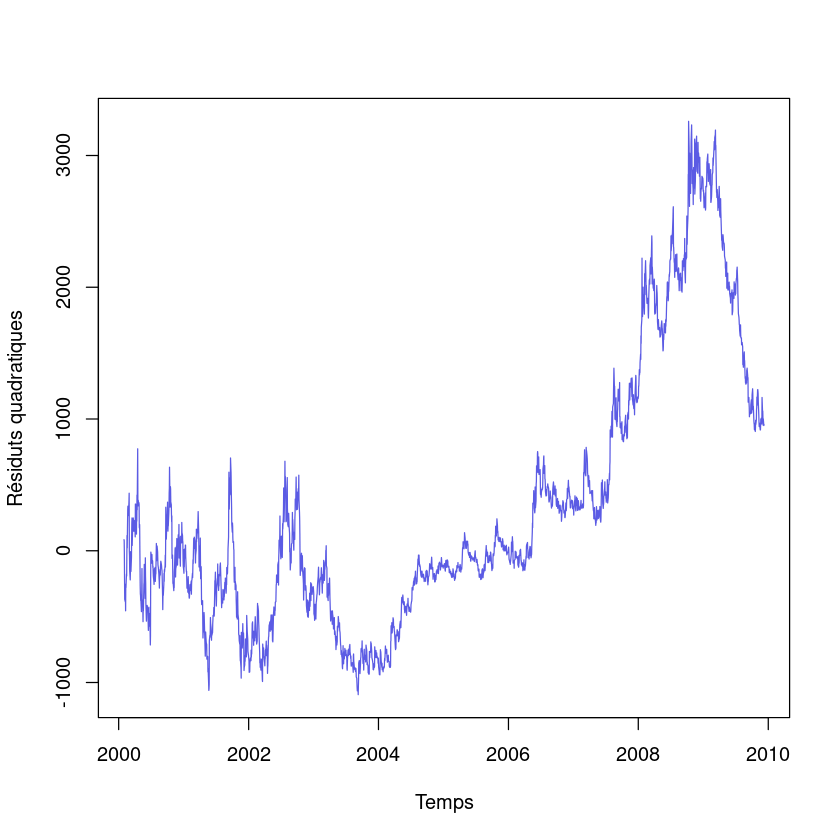

In [246]:
plot(linear_result$Date, linear_result$residuals, type="l", xlab="Temps", ylab="Résiduts linéaires", col="#f34c4c")
plot(exp_result$Date, exp_result$residuals, type="l", col="#79bd79", xlab="Temps", ylab="Résiduts exponentiels")
plot(quadratic_result$Date, quadratic_result$residuals, type="l", col="#5b5be4", xlab="Temps", ylab="Résiduts quadratiques")